In [9]:
import pickle
import pandas as pd
import torch

In [91]:
import torch
import numpy as np
from torch_geometric.utils import to_edge_index
import matplotlib.pyplot as plt
import networkx as nx
import snf

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def print_hist(edge_attr):
    plt.hist(edge_attr, log=True, ec="black")
    plt.xlabel("Normalised distance value")
    plt.ylabel("Counts (log)")
    plt.show()


def min_max_normalisation(X):
    return (X - X.min()) / (X.max() - X.min())

def get_edge_index(X, threshold=None, N_largest=None):
    if N_largest:
        idx = np.argpartition(X.ravel(), -N_largest * 2)[-N_largest * 2 :]
        threshold = X.ravel()[idx].min()

    if threshold:
        X[X < threshold] = 0

    return to_edge_index((torch.tensor(X, dtype=torch.float).to_sparse()))

def print_graph(edge_index, nodes_n):
    H = nx.Graph()
    # H.add_nodes_from(np.unique(edge_index.flatten()))
    H.add_nodes_from(np.arange(0,nodes_n+1))
    edges = [(int(e[0]), int(e[1])) for e in zip(edge_index[0], edge_index[1])]
    H.add_edges_from(edges)

    G = nx.Graph()
    G.add_nodes_from(sorted(H.nodes(data=True)))
    G.add_edges_from(H.edges(data=True))

    nx.draw_networkx(
        G,
        with_labels=False,
        # node_color=labels[np.array(G.nodes())].tolist(),
        # node_color=labels,
        node_size=1,
        width=0.25,
    )
    # nx.draw_networkx(G, with_labels=False, node_size=1, width=0.25)

    print("Total number of nodes: ", int(G.number_of_nodes()))
    print("Number of isolated nodes: ", nx.number_of_isolates(G))
    print("Total number of edges: ", int(G.number_of_edges()))
    print("Max Degree for all nodes: ", np.array(G.degree())[:, 1].max())
    print("Total number of self-loops: ", int(nx.number_of_selfloops(G)))

    return G

# MoGCN

In [92]:
SNF_fused_matrix_path = "./data/MoGCN_results/SNF_fused_matrix.csv"
adj = pd.read_csv(SNF_fused_matrix_path)
n_nodes = len(adj)
adj = adj.iloc[:,1:].values
np.fill_diagonal(adj, 0)
edge_index, edge_attr = get_edge_index(adj, threshold=0.005)

Total number of nodes:  512
Number of isolated nodes:  273
Total number of edges:  433
Max Degree for all nodes:  18
Total number of self-loops:  0


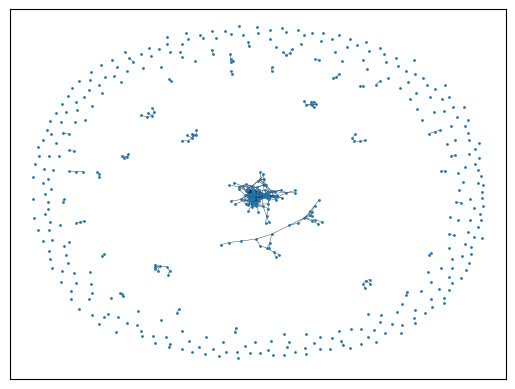

In [93]:
print_graph(edge_index,n_nodes)

# SUPREME

In [94]:
cna_edges_path = "./data/SUPREME/sample_data/edges_cna.pkl"
cna_edges = pd.read_pickle(cna_edges_path)
cna_edges["Var1"] = pd.to_numeric(cna_edges["Var1"])
cna_edges["Var2"] = pd.to_numeric(cna_edges["Var2"])
cna_edges = cna_edges.reset_index(drop=True)
# cna_edges = cna_edges[["Var1","Var2"]]
cna_edges.dtypes

Var1       int64
Var2       int64
value    float64
dtype: object

In [95]:
# cna_edges = cna_edges.drop_duplicates(subset=["Var1","Var2"],ignore_index=True, keep="first")
# cna_edges

In [96]:
edge_index = [[],[]]
for i, x in enumerate(zip(cna_edges["Var1"].to_list(), cna_edges["Var2"].to_list())):
    if(x[0]!=x[1]):
        edge_index[0].append(x[0])
        edge_index[1].append(x[1])

edge_index = torch.tensor(edge_index,dtype=torch.long)

Total number of nodes:  258
Number of isolated nodes:  238
Total number of edges:  34
Max Degree for all nodes:  9
Total number of self-loops:  0


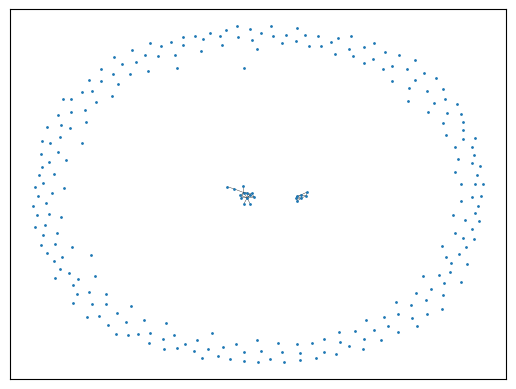

In [97]:
print_graph(edge_index, 257)